A Quantum Covariance Matrix (QCM) is a quantum geenralization of a classical covariance matrix where statistical expectation values of random variables under a probability distribution are replaced by quantum expectation values of Hermitian operators under a wave function. (Clark, 2018)

$$ (C_T)_{a,b} := \langle \hat{h}_a \hat{h}_b \rangle - \langle \hat{h}_a \rangle \langle \hat{h}_b \rangle $$

Using Matrix Product State (MPS) representation of wavefunctions, we can easily use TeNPy to reproduce some certain QCM with local Hamiltonians of interests.
In TeNPy, there are many intuitive implementations of local Hamiltonians called 'terms', which are super helpful for this task.

In [15]:
import tenpy
from tenpy.networks.terms import TermList
from tenpy.models.lattice import Lattice
from tenpy.networks.site import SpinHalfFermionSite

import numpy as np
import matplotlib.pyplot as plt

# Override the Python mutliplication

In [2]:
def mul(self, other:TermList):
    """
        Override the mul func to make sure the multiplication between TermList works
    """
    terms = []
    strength = []
    for termlist1 in self:
        for termlist2 in other:
            termlist = termlist1[0] + termlist2[0]
            terms.append(termlist)
            strength.append(termlist1[1] * termlist2[1])
    return TermList(terms, strength)
TermList.__mul__ = mul

# A class for QCM

In [3]:
class QCM:
    def __init__(self, psi, h_list):
        self.psi = psi.copy() # MPS
        self.h_list = h_list # the basis vector h_a, a list of TermList
        
        self.calc_average_ha() # the average, i.e. expectation value of each basis
        self.calc_average_hahb() # the cross terms
        self.calc_QCM()
        
    def calc_average_ha(self):
        """
            Calculate the expectation values of each basis Hamiltonian,
            by seeing each as a sum of local operators and then directly calculating
            the expectation value
        """
        self.average_ha = [self.psi.expectation_value_terms_sum(h)[0] for h in self.h_list]
    def calc_average_hahb(self):
        """
            The cross values...
        """
        n = len(self.h_list)
        self.ab_matrix = np.zeros((n, n), dtype='complex64')
        for i in range(n):
            for j in range(n):
                self.ab_matrix[i, j] = self.psi.expectation_value_terms_sum(self.h_list[i] * self.h_list[j])[0]
    def calc_QCM(self):
        n = len(self.h_list)
        mat = self.ab_matrix.copy()
        for i in range(n):
            for j in range(n):
                mat[i, j] -= self.average_ha[i]*self.average_ha[j]
        self.qcm = mat

# Tests on the class `TermList`

In [4]:
import tenpy
from tenpy.networks.terms import TermList

import numpy as np

In [5]:
tl = TermList([[('Cd', 0), ('C', 2)], [('Cd', 2), ('C', 0)], [('N', 1)]],
...              [0.5,                   0.5,                   1.3])

In [6]:
for t in tl:
    print(t)

([('Cd', 0), ('C', 2)], 0.5)
([('Cd', 2), ('C', 0)], 0.5)
([('N', 1)], 1.3)


Just as TeNPy's documentation has indicated, the class `TermList` defines a list of 'terms', each of which are composed of the local operator tensored together along with their prefactors.

In [7]:
tl.__len__ = print

In [8]:
def mul(self, other):
    terms = []
    strength = []
    for termlist1 in self:
        for termlist2 in other:
            termlist = termlist1[0] + termlist2[0]
            terms.append(termlist)
            strength.append(termlist1[1] * termlist2[1])
    return TermList(terms, strength)
TermList.__mul__ = mul

In [9]:
print(tl * tl)

0.25000 * Cd_0 C_2 Cd_0 C_2 +
0.25000 * Cd_0 C_2 Cd_2 C_0 +
0.65000 * Cd_0 C_2 N_1 +
0.25000 * Cd_2 C_0 Cd_0 C_2 +
0.25000 * Cd_2 C_0 Cd_2 C_0 +
0.65000 * Cd_2 C_0 N_1 +
0.65000 * N_1 Cd_0 C_2 +
0.65000 * N_1 Cd_2 C_0 +
1.69000 * N_1 N_1


# A benchmark with Rouchen's computation

This result should be equivalent to the result of https://github.com/ruochenma/Chiral-Spin-Liquid/blob/qcm/invert.py

In [10]:
Lx,Ly=2,4
L=2*Lx*Ly

Sp = 'Sp'
Sm = 'Sm'
Sz = 'Sz'

# 16 possible local couplings. NN and nNN hoping, SxSx+SySy vs. SzSz, two sublattices
op_list=[[Sp, Sm, 1, 0], [Sm, Sp, 1, 0], [Sp, Sm, 1, 1], [Sm, Sp, 1, 1],\
         [Sz, Sz, 1, 0], [Sz, Sz, 1, 0], [Sz, Sz, 1, 1], [Sz, Sz, 1, 1],\
         [Sp, Sm, 2, 0], [Sm, Sp, 2, 0], [Sp, Sm, 2, 1], [Sm, Sp, 2, 1],\
         [Sz, Sz, 2, 0], [Sz, Sz, 2, 0], [Sz, Sz, 2, 1], [Sz, Sz, 2, 1],\
         [Sp, Sm, 2*Ly-1, 0], [Sm, Sp, 2*Ly-1, 0], [Sp, Sm, 2*Ly-1, 1], [Sm, Sp, 2*Ly-1, 1],\
         [Sz, Sz, 2*Ly-1, 0], [Sz, Sz, 2*Ly-1, 0], [Sz, Sz, 2*Ly-1, 1], [Sz, Sz, 2*Ly-1, 1],\
         [Sp, Sm, 3, 0], [Sm, Sp, 3, 0], [Sp, Sm, 3, 1], [Sm, Sp, 3, 1],\
         [Sz, Sz, 3, 0], [Sz, Sz, 3, 0], [Sz, Sz, 3, 1], [Sz, Sz, 3, 1]]

Issue: we need to know the explicit expression of variables `Sp`, `Sm` and `Sz`.

In [11]:
h_list = []

for i in range(L):
    tl = []
    if op_list[2*i][3]==0:
        for m in range(L):
            if m%2==0:
                if m%(2*Ly) +op_list[2*i][2] < 2*Ly:
#                     exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])])\
#                         +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )])
                    tl += [
                        [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])], 
                        [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )]
                    ]
                else:
#                     exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)])\
#                         +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )])
                    tl += [
                        [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)],
                        [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )]
                    ]
                    
    else:
        if op_list[2*i][2]%2==0:
            for m in range(L):
                if m%2 !=0:
                    if m%(2*Ly) +op_list[2*i][2] < 2*Ly:

#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )])
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2])],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]  )]
                        ]
                    else:
#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )])
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2*Ly)],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2*Ly  )],
                        ]
                    
        else: 
            for m in range(L):
                if m%2 !=0:

                    if m%(2*Ly) +op_list[2*i][2] + 2*Ly-2 < 4*Ly:
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2)],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  )],
                        ]
#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]+2*Ly-2)])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]+2*Ly-2  )])
                    else:
#                         exp+=psi.expectation_value_term([(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  )])\
#                             +psi.expectation_value_term([(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  )])
                        tl += [
                            [(op_list[2*i][0] , m),(op_list[2*i][1], m+op_list[2*i][2]-2  )],
                            [(op_list[2*i+1][0] , m),(op_list[2*i+1][1], m+op_list[2*i+1][2]-2  )],
                        ]
    h_list.append(TermList(terms=tl))

In [14]:
for i, h in enumerate(h_list):
    print(i)
    print(h)
    print('')

0
1.00000 * Sp_0 Sm_1 +
1.00000 * Sm_0 Sp_1 +
1.00000 * Sp_2 Sm_3 +
1.00000 * Sm_2 Sp_3 +
1.00000 * Sp_4 Sm_5 +
1.00000 * Sm_4 Sp_5 +
1.00000 * Sp_6 Sm_7 +
1.00000 * Sm_6 Sp_7 +
1.00000 * Sp_8 Sm_9 +
1.00000 * Sm_8 Sp_9 +
1.00000 * Sp_10 Sm_11 +
1.00000 * Sm_10 Sp_11 +
1.00000 * Sp_12 Sm_13 +
1.00000 * Sm_12 Sp_13 +
1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15

1
1.00000 * Sp_1 Sm_8 +
1.00000 * Sm_1 Sp_8 +
1.00000 * Sp_3 Sm_10 +
1.00000 * Sm_3 Sp_10 +
1.00000 * Sp_5 Sm_12 +
1.00000 * Sm_5 Sp_12 +
1.00000 * Sp_7 Sm_14 +
1.00000 * Sm_7 Sp_14 +
1.00000 * Sp_9 Sm_16 +
1.00000 * Sm_9 Sp_16 +
1.00000 * Sp_11 Sm_18 +
1.00000 * Sm_11 Sp_18 +
1.00000 * Sp_13 Sm_20 +
1.00000 * Sm_13 Sp_20 +
1.00000 * Sp_15 Sm_22 +
1.00000 * Sm_15 Sp_22

2
1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_10 Sz_11 +
1.00000 * Sz_10 

# A system for self-defining translationally-invariant Hamiltonian basis

In [16]:
model_params = {
    'Lx': 2, 'Ly': 4, 'bc':'periodic',# Ly is set below
    'bc_MPS': 'infinite',
    'verbose': 1,
    'cons_N': 'N',
    'cons_Sz': 'Sz',
    't': 1,
    'td': 0.5j,
}



class twosites(Lattice):
    def __init__(self, Lx, Ly, site, **kwargs):
        
        """
            The first following block is for the plotting
        """
#         sites = _parse_sites(sites, 2)
        basis = np.array(([1., 0.], [0., 1.]))
        delta = np.array([1., 0.])
        pos = (-delta / 4., delta / 4.)
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
     
       
        """
            The second is for the pairs' definition
        """
        NN = [(0, 1, np.array([0, 0])), (1, 0, np.array([1, 0])), (0, 0, np.array([0, 1]))]
        NNa = [(1, 1, np.array([0, 1]))]
        nNN = [(0, 1, np.array([0, 1])), (1, 0, np.array([0, 1])),(1, 0, np.array([1, -1])), (0, 1, np.array([-1, -1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors', NN)
        kwargs['pairs'].setdefault('next_nearest_neighbors', NNa)
        kwargs['pairs'].setdefault('next_next_nearest_neighbors', nNN)
        Lattice.__init__(self, [Lx, Ly], site, **kwargs)



In [17]:
fs = SpinHalfFermionSite()
lat = twosites(Lx = 2, Ly = 4, site=[fs, fs], bc='periodic', bc_MPS='infinite')

In [18]:
lat.pairs

{'nearest_neighbors': [(0, 1, array([0, 0])),
  (1, 0, array([1, 0])),
  (0, 0, array([0, 1]))],
 'next_nearest_neighbors': [(1, 1, array([0, 1]))],
 'next_next_nearest_neighbors': [(0, 1, array([0, 1])),
  (1, 0, array([0, 1])),
  (1, 0, array([ 1, -1])),
  (0, 1, array([-1, -1]))]}

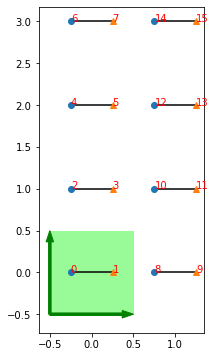

In [21]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['nearest_neighbors'][0]])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

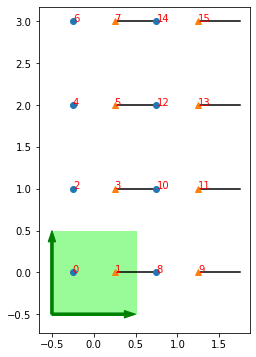

In [22]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['nearest_neighbors'][1]])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

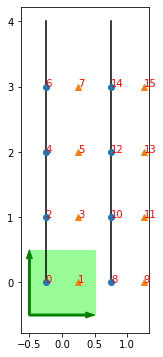

In [23]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['nearest_neighbors'][2]])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

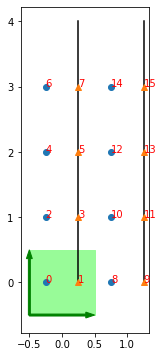

In [24]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, lat.pairs['next_nearest_neighbors'])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

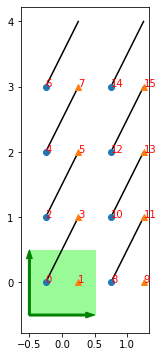

In [25]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['next_next_nearest_neighbors'][0]])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

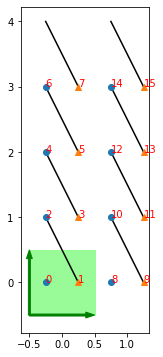

In [26]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['next_next_nearest_neighbors'][1]])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

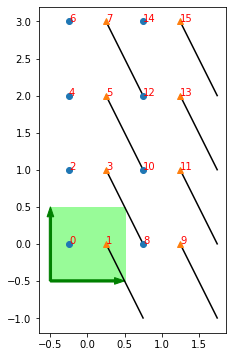

In [27]:
plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax, [lat.pairs['next_next_nearest_neighbors'][2]])

lat.plot_sites(ax)
lat.plot_order(ax, linestyle='')

lat.plot_basis(ax, origin=-0.5*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
# ax.legend()

# With the given input `Lattice`, automatically calc the basis vec

In [28]:
def symmetric_op_term(op_list):
    assert len(op_list)==2 # just implemneted the 2-site coupling...
    op0, i0 = op_list[0]
    op1, i1 = op_list[1]
    return [[(op0, i0), (op1, i1)], [(op1, i0), (op0, i1)]]
op_list_test = [('Sp', 0), ('Sm', 1)]
symmetric_op_term(op_list_test)

[[('Sp', 0), ('Sm', 1)], [('Sm', 0), ('Sp', 1)]]

In [29]:
def generate_h_base(
    lat, 
    op_pairs=[['Sp', 'Sm'], ['Sz', 'Sz']],
):
    """
        Automatically generate the Hamiltonian basis vectors,
        given a lattice and the operator pairs (a list of lists of operators)
    """
    
    h_base = []
    for op_list in op_pairs:
        op0 = op_list[0]
        op1 = op_list[1]
        for pair in lat.pairs.values():
            for u1, u2, dx in pair:
                hh = []
                mps_i, mps_j, _, _ = lat.possible_couplings(u1, u2, dx)
                for i in range(len(mps_i)):
                    site0 = mps_i[i]
                    site1 = mps_j[i]
                    op_list = [(op0, site0), (op1, site1)]
                    hh += symmetric_op_term(op_list)
                h_base.append(TermList(terms=hh))
    return h_base

h_base_new = generate_h_base(lat)

### `h_base_new` is the base vector automatically generated

In [30]:
for i, h in enumerate(h_base_new):
    print(i)
    print(h)
    print('')
    

0
1.00000 * Sp_0 Sm_1 +
1.00000 * Sm_0 Sp_1 +
1.00000 * Sp_2 Sm_3 +
1.00000 * Sm_2 Sp_3 +
1.00000 * Sp_4 Sm_5 +
1.00000 * Sm_4 Sp_5 +
1.00000 * Sp_6 Sm_7 +
1.00000 * Sm_6 Sp_7 +
1.00000 * Sp_8 Sm_9 +
1.00000 * Sm_8 Sp_9 +
1.00000 * Sp_10 Sm_11 +
1.00000 * Sm_10 Sp_11 +
1.00000 * Sp_12 Sm_13 +
1.00000 * Sm_12 Sp_13 +
1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15

1
1.00000 * Sp_1 Sm_8 +
1.00000 * Sm_1 Sp_8 +
1.00000 * Sp_3 Sm_10 +
1.00000 * Sm_3 Sp_10 +
1.00000 * Sp_5 Sm_12 +
1.00000 * Sm_5 Sp_12 +
1.00000 * Sp_7 Sm_14 +
1.00000 * Sm_7 Sp_14 +
1.00000 * Sp_9 Sm_16 +
1.00000 * Sm_9 Sp_16 +
1.00000 * Sp_11 Sm_18 +
1.00000 * Sm_11 Sp_18 +
1.00000 * Sp_13 Sm_20 +
1.00000 * Sm_13 Sp_20 +
1.00000 * Sp_15 Sm_22 +
1.00000 * Sm_15 Sp_22

2
1.00000 * Sp_0 Sm_2 +
1.00000 * Sm_0 Sp_2 +
1.00000 * Sp_2 Sm_4 +
1.00000 * Sm_2 Sp_4 +
1.00000 * Sp_4 Sm_6 +
1.00000 * Sm_4 Sp_6 +
1.00000 * Sp_6 Sm_0 +
1.00000 * Sm_6 Sp_0 +
1.00000 * Sp_8 Sm_10 +
1.00000 * Sm_8 Sp_10 +
1.00000 * Sp_10 Sm_12 +
1.00000 * Sm_1

### `h_list` is the base vector given by RC's code

In [31]:
for i, h in enumerate(h_list):
    print(i)
    print(h)
    print('')
    

0
1.00000 * Sp_0 Sm_1 +
1.00000 * Sm_0 Sp_1 +
1.00000 * Sp_2 Sm_3 +
1.00000 * Sm_2 Sp_3 +
1.00000 * Sp_4 Sm_5 +
1.00000 * Sm_4 Sp_5 +
1.00000 * Sp_6 Sm_7 +
1.00000 * Sm_6 Sp_7 +
1.00000 * Sp_8 Sm_9 +
1.00000 * Sm_8 Sp_9 +
1.00000 * Sp_10 Sm_11 +
1.00000 * Sm_10 Sp_11 +
1.00000 * Sp_12 Sm_13 +
1.00000 * Sm_12 Sp_13 +
1.00000 * Sp_14 Sm_15 +
1.00000 * Sm_14 Sp_15

1
1.00000 * Sp_1 Sm_8 +
1.00000 * Sm_1 Sp_8 +
1.00000 * Sp_3 Sm_10 +
1.00000 * Sm_3 Sp_10 +
1.00000 * Sp_5 Sm_12 +
1.00000 * Sm_5 Sp_12 +
1.00000 * Sp_7 Sm_14 +
1.00000 * Sm_7 Sp_14 +
1.00000 * Sp_9 Sm_16 +
1.00000 * Sm_9 Sp_16 +
1.00000 * Sp_11 Sm_18 +
1.00000 * Sm_11 Sp_18 +
1.00000 * Sp_13 Sm_20 +
1.00000 * Sm_13 Sp_20 +
1.00000 * Sp_15 Sm_22 +
1.00000 * Sm_15 Sp_22

2
1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_0 Sz_1 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_2 Sz_3 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_4 Sz_5 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_6 Sz_7 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_8 Sz_9 +
1.00000 * Sz_10 Sz_11 +
1.00000 * Sz_10 